In [1]:
import requests
from pprint import pprint


In [2]:

API_KEY = 'dTG9TTr1g1HDnhd5GXJgoX0jKXmXHm3g'

url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"
params = {
    "begin_date": "20220301",
    "end_date": "20220308",
    "sort": "best",
    "fq": 'section.name:("U.S." "World")',
    "api-key": API_KEY
}

In [3]:

response = requests.get(url, params=params)
data = response.json()


In [13]:
# Create an empty list to store titles
titles = []

# Loop through the articles and extract titles
for article in data['response']['docs']:
    title = article['headline']['main']  # Get the main headline
    titles.append(title)  # Store the title in the array

    # Optionally, you can print other details if you like
    print(f"Title: {title}")
    print(f"Date: {article['pub_date']}")
    print(f"URL: {article['web_url']}")
    print(f"Section: {article.get('section_name')}")
    print(f"Word count: {article.get('word_count')}")
    print("-" * 50)

# Now the 'titles' array holds all the titles from the articles
print("Titles array:", titles)


Title: Humanitarian Crisis Worsens for Ukrainians Trapped in Russia’s Onslaught
Date: 2022-03-07T23:26:48Z
URL: https://www.nytimes.com/2022/03/07/world/europe/ukraine-humanitarian-crisis-russia.html
Section: World
Word count: 1444
--------------------------------------------------
Title: Once victims in southeast Europe, Jews come to the aid of fleeing Ukrainians.
Date: 2022-03-07T23:25:30Z
URL: https://www.nytimes.com/live/2022/03/07/world/ukraine-russia-war/once-victims-in-southeast-europe-jews-come-to-the-aid-of-fleeing-ukrainians
Section: World
Word count: 223
--------------------------------------------------
Title: The third round of Ukraine-Russia talks renew the prospect of humanitarian corridors.
Date: 2022-03-07T22:41:58Z
URL: https://www.nytimes.com/live/2022/03/07/world/ukraine-russia-war/the-third-round-of-ukraine-russia-talks-renew-the-prospect-of-humanitarian-corridors
Section: World
Word count: 312
--------------------------------------------------
Title: Once Victims 

In [7]:
title = article['headline']['main']
title

'Pentagon sends 500 additional troops to Europe.'

In [12]:
from transformers import pipeline


In [18]:
# Initialize sentiment-analysis pipeline using RoBERTa

sentiment_pipeline = pipeline("text-classification", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

C:\Users\zecab\PyCharmMiscProject\.venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zecab\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not 

In [19]:
result = sentiment_pipeline(titles)
print(result)

[{'label': 'NEGATIVE', 'score': 0.9948575496673584}, {'label': 'POSITIVE', 'score': 0.9200932383537292}, {'label': 'POSITIVE', 'score': 0.9836747646331787}, {'label': 'POSITIVE', 'score': 0.6001744866371155}, {'label': 'POSITIVE', 'score': 0.9965617060661316}, {'label': 'NEGATIVE', 'score': 0.9722307324409485}, {'label': 'NEGATIVE', 'score': 0.9702109694480896}, {'label': 'NEGATIVE', 'score': 0.9934506416320801}, {'label': 'NEGATIVE', 'score': 0.9948418736457825}, {'label': 'POSITIVE', 'score': 0.7778358459472656}]


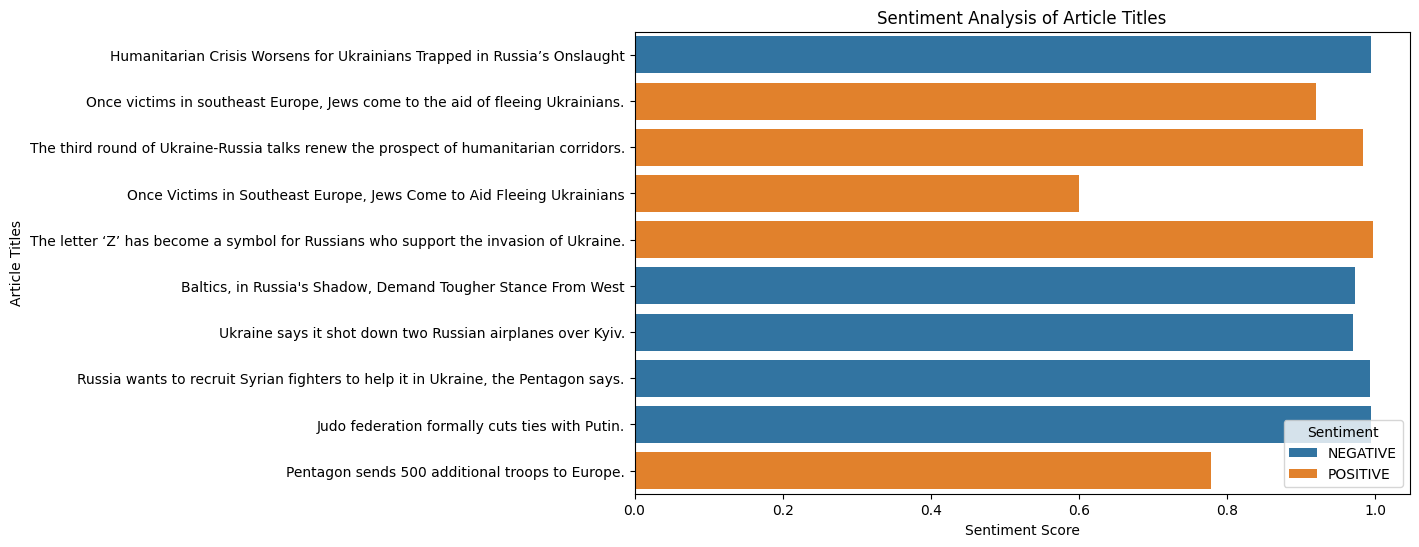

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example 'titles_' is the list of article titles you stored in the previous code
# Assuming 'result' contains sentiment analysis output from the sentiment_pipeline
# result = sentiment_pipeline(titles_)

# Extracting sentiment labels and scores from the result
labels = [res['label'] for res in result]
scores = [res['score'] for res in result]

# Create a DataFrame for easy plotting
df = pd.DataFrame({
    'Title': titles,  # The titles of the articles
    'Sentiment': labels,  # Sentiment labels (Positive, Negative, Neutral)
    'Sentiment Score': scores  # Sentiment scores
})

# Set up the Seaborn plot
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(x='Sentiment Score', y='Title', data=df, hue='Sentiment', dodge=False)

# Customize the plot
plt.title('Sentiment Analysis of Article Titles')
plt.xlabel('Sentiment Score')
plt.ylabel('Article Titles')

# Show the plot
plt.show()


In [21]:
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt

# List of titles


# Load model
model = SentenceTransformer("jinaai/jina-embeddings-v2-base-en", trust_remote_code=True)

# Encode titles
embeddings = model.encode(titles)

# Calculate similarity matrix
similarities = model.similarity(embeddings, embeddings)

# Print similarity matrix shape
print("Similarity Matrix Shape:", similarities.shape)

# Optional: Display similarity matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarities, xticklabels=titles, yticklabels=titles, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Semantic Similarity Between Article Titles")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


C:\Users\zecab\PyCharmMiscProject\.venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zecab\.cache\huggingface\hub\models--jinaai--jina-embeddings-v2-base-en. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\zecab\PyCharmMiscProject\.venv\Lib\site-packages\huggingface_hub\file_download.py:144:

Similarity Matrix Shape: torch.Size([10, 10])


NameError: name 'titles_' is not defined

<Figure size 1000x800 with 0 Axes>

In [24]:
title_embeddings = {title: embedding for title, embedding in zip(titles, embeddings)}

# Print each title and the first few numbers from its embedding
for title, embedding in title_embeddings.items():
    print(f"Title: {title}")
    print(f"Embedding (first 5 dims): {embedding[:5]}")
    print("-" * 50)

Title: Humanitarian Crisis Worsens for Ukrainians Trapped in Russia’s Onslaught
Embedding (first 5 dims): [ 0.01760884  0.00662342  0.03132039  0.00578034 -0.01730509]
--------------------------------------------------
Title: Once victims in southeast Europe, Jews come to the aid of fleeing Ukrainians.
Embedding (first 5 dims): [-0.01828226 -0.00858354  0.05791586 -0.0190194  -0.01431176]
--------------------------------------------------
Title: The third round of Ukraine-Russia talks renew the prospect of humanitarian corridors.
Embedding (first 5 dims): [-0.02694514 -0.0015462   0.06325768 -0.01208687 -0.01913327]
--------------------------------------------------
Title: Once Victims in Southeast Europe, Jews Come to Aid Fleeing Ukrainians
Embedding (first 5 dims): [-0.01464243 -0.00163504  0.05857609 -0.01858301 -0.01539349]
--------------------------------------------------
Title: The letter ‘Z’ has become a symbol for Russians who support the invasion of Ukraine.
Embedding (first 